In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import shap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from scipy.stats import mode

/home/lucas/miniconda3/envs/shap/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 1337

In [3]:
df = pd.read_csv('preprocessed.csv')

In [4]:
def normalize_features(df, use_log=True):
    df = df.copy()
    for col in df.columns[1:]:
        if use_log:
            df[col] = df[col].apply(lambda x: np.log(x + 1))
        df[col] = MinMaxScaler().fit_transform(df[col].values.reshape(-1, 1)).flatten()
    return df

In [5]:
def get_vote(metric_function, comparator, norm, min_number, max_number, model=KMeans):
    possible_k = list(range(min_number, max_number + 1))[::-1]
    scores = {k: None for k in possible_k}
    for k in possible_k:
        print('Trying k', k, 'and fitting KMeans')
        l = model(n_clusters=k, random_state=RANDOM_STATE).fit_predict(norm)
        try:
            scores[k] = metric_function(norm, l, random_state=RANDOM_STATE)
        except:
            scores[k] = metric_function(norm, l)
        print('Scored.')
    best_k = max_number
    last_k = best_k
    def comp(x, y, method):
        if method == 'gt':
            return x > y
        elif method == 'lt':
            return x < y
    for k in scores:
        if comp(scores[k], scores[best_k], comparator) and \
        (abs(scores[k] - scores[last_k]) >= 0.1 * scores[last_k]):
            last_k = best_k
            best_k = k
    return best_k

def get_cluster_number(normalized_df, min_number=2, max_number=7, model=KMeans):
    votes = []
    metrics = [
        (silhouette_score, 'gt'),
        # add more later
    ]
    for metric in metrics:
        print('Getting vote for metric', metric[0].__name__)
        votes.append(
            get_vote(metric_function=metric[0], comparator=metric[1], norm=normalized_df, min_number=min_number, max_number=max_number, model=model)
        )
    return mode(votes)[0][0], {x[0].__name__: votes[i] for i, x in enumerate(metrics)}

def clusterize_students(df, use_log=True, model=KMeans, min_c=2, max_c=7):
    df = df.copy()
    print('Normalizing features')
    norm = normalize_features(df)
    print('Getting cluster number')
    n_clusters, _ = get_cluster_number(norm, model=model, min_number=min_c, max_number=max_c)
    print(n_clusters, 'seems like the best number of clusters')
    print('Creating model')
    m = model(n_clusters=n_clusters, random_state=RANDOM_STATE)
    labels = m.fit_predict(norm.iloc[:, 1:])
    df['cluster'] = labels
    norm['cluster'] = labels
    return df, norm, n_clusters

In [ ]:
try:
    df = df_.copy()
except: pass
df_ = df.copy()
# etnias = [x for x in list(df.columns) if x.startswith('etnia_')]
# rendas = [x for x in list(df.columns) if x.startswith('renda_')]
cols = ['n_cn', 'n_ch', 'n_lc', 'n_mt', 'n_r'] # + rendas # + etnias
medias = {x: df[x].mean() for x in cols}
for col in cols:
    df[col] = df[col].apply(lambda x: x / (medias[col] or x))
# print('Getting acesso_informacao')
# acesso_informacao = (df['computadores'] + df['celulares'] + df['internet'])
# print('Applying')
# acesso_informacao = acesso_informacao.apply(lambda x: 1 if x > 0 else 0)
df = df[['id'] + cols]
# df['acesso_informacao'] = acesso_informacao

print('Clusterizing')
subset = df#.sample(n=10000)
clusterized, normalized, n_clusters = clusterize_students(subset, min_c=5, max_c=5)
train, test = train_test_split(clusterized, test_size=0.25)
ntrain, ntest = train_test_split(normalized, test_size=0.25)
print('Done!')

Clusterizing
Normalizing features
Getting cluster number
Getting vote for metric silhouette_score
Trying k 5 and fitting KMeans


In [8]:
# Select best parameters for the classifier
def select_best_params(model, params, df):
    features = df.iloc[:, 1:-1]
    targets = df['cluster']
    gcv = GridSearchCV(model(), params)
    gcv.fit(features, targets)
    return gcv.best_params_

def get_models(model, params, df, n_clusters):
    models = []
    for i in range(n_clusters):
        print('Model', i)
        c_i = df.copy()
        print('Copied DF')
        c_i['cluster'] = c_i['cluster'].apply(
            lambda x: 1 if int(x) == i else 0
        )
        print('Cluster 0-1 applied')
        print('Searching with GridCV')
        p = select_best_params(model, params, c_i)
        print('Creating model with best params')
        model_c = model(**p)
        # todo: balancear
        inputs = c_i.iloc[:, 1:-1].values
        targets = c_i['cluster'].values
        print('Fitting model.')
        model_c.fit(inputs, targets)
        # score = cross_val_score(model_c, inputs.copy(), targets.copy(), cv=5)
        print('Done.\n')
        # models.append((model_c, score))
        models.append((model_c,))
    # sort by best over-all score
    # models = sorted(models, key=lambda x: sum(x[1].tolist()), reverse=True)
    return models

In [9]:
def calc_shap_plot_params(models, df, ndf):
    df = df.copy()
    r = []
    for i, model in enumerate(models):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(df.iloc[:, 1:-1])
        shap_sum = np.abs(shap_values).mean(axis=0)
        importance_df = pd.DataFrame([df.columns.tolist()[1:-1], shap_sum.tolist()]).T
        importance_df.columns = ['column_name', 'shap_importance']
        importance_df = importance_df.sort_values('shap_importance', ascending=True)
        importance_df['shap_importance'] = importance_df['shap_importance'].astype(np.float64)
        r.append((importance_df, shap_sum, shap_values))
    return r

def plot_shap(importance_df, shap_sum, shap_values, dataset, step=5, drop_zeroes=True, show_plot=False, save_path=None, shap_val_path=None):
    plt.clf()
    if drop_zeroes:
        importance_df = importance_df[importance_df['shap_importance'] > 0]
    if shap_val_path:
        shap.summary_plot(shap_values, dataset.iloc[:, 1:-1], show=False)
        plt.savefig(shap_val_path)
    n_cols = importance_df.shape[0]
    x = np.zeros(n_cols)
    y = range(n_cols)
    maxx = 0.0
    for i in range(n_cols):
        new_max = importance_df.iloc[i, 1] / np.sum(shap_sum)
        x[i] = new_max
        maxx = max(maxx, new_max)
    
    fig = plt.figure(figsize=(20, 15))
    barlist = plt.barh(y, x, align='center', edgecolor='black')
    
    plt.yticks(range(n_cols), importance_df['column_name'], fontsize=12)
    
    xlabels = []    
    for i in np.arange(0, maxx * 100, step):
        tt = str(i) + '%'
        xlabels.append(tt)
    for i, val in enumerate(x):
        plt.text(val, i, ' {:.2%}'.format(val), va='center')
    plt.xticks(np.arange(0, maxx, step / 100.0), xlabels, fontsize=15)
    plt.xlabel('Percentage of Importance', size=15)
    plt.title('Importance of Each Feature in Final Classification', size=12)
    if save_path is not None:
        plt.savefig(save_path)
    if show_plot:
        plt.show()
    plt.close(fig)

In [10]:
def ovr_predict(models, user):
    for i, model in enumerate(models):
        pred = model.predict(np.array([user.values.flatten()])).flatten()
        if pred == 1:
            return i
    return -1

In [11]:
from tqdm import tqdm

In [12]:
def describe_clusters(clusterized, norm_clusterized, n_clusters, model, params):
    # WHENEVER YOU'RE DEALING WITH MODEL FITTING OR PREDICTIONS (INCLUDING SHAP VALUES),
    # MAKE SURE YOU USE THE APPROPRIATE DATAFRAME. SINCE XGBCLASSIFIER DOES NOT REQUIRE
    # NORMALIZATION, IT IS FINE TO USE clusterized INSTEAD OF norm_clusterized. CHANGE
    # ACCORDING TO YOUR NEEDS (AND MODEL USED).
    clusterized = clusterized.copy()
    norm_clusterized = norm_clusterized.copy()
    print('Creating models...')
    models_tuples = get_models(model, params, clusterized, n_clusters)
    models = []
    for tup in models_tuples:
        models.append(tup[0])
    
    print('Predicting every single entry...')
    for i, row in tqdm(clusterized.iterrows(), total=len(clusterized)):
        pred = ovr_predict(models, row.iloc[1:-1])
        clusterized.at[i, 'cluster'] = pred
        norm_clusterized.at[i, 'cluster'] = pred
    shap_params = calc_shap_plot_params(models, clusterized, norm_clusterized)
    for i, (importance_df, shap_sum, shap_values) in enumerate(shap_params):
        plt.clf()
        importances_dict = {}
        important_columns = importance_df['column_name'].values.tolist()
        shap_importances = [x / np.sum(shap_sum) for x in importance_df['shap_importance'].values.tolist()]
        # shap_importances = importance_df['shap_importance'].values.tolist() # revert if things break
        for j in range(len(important_columns)):
            importances_dict[important_columns[j]] = shap_importances[j]
        plot_shap(importance_df, shap_sum, shap_values, clusterized, step=2.5, save_path='model' + str(i) + '_important_features.jpg', shap_val_path='model' + str(i) + '_shap_values.jpg')
    return models

In [13]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Creating models...
Model 0
Copied DF
Cluster 0-1 applied
Searching with GridCV
Creating model with best params
Fitting model.
Done.

Model 1
Copied DF
Cluster 0-1 applied
Searching with GridCV
Creating model with best params
Fitting model.
Done.

Model 2
Copied DF
Cluster 0-1 applied
Searching with GridCV
Creating model with best params
Fitting model.
Done.

Model 3
Copied DF
Cluster 0-1 applied
Searching with GridCV
Creating model with best params
Fitting model.
Done.

Model 4
Copied DF
Cluster 0-1 applied
Searching with GridCV
Creating model with best params
Fitting model.
Done.

Predicting every single entry...


100%|████████████████████████████████████| 50000/50000 [04:21<00:00, 191.45it/s]
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


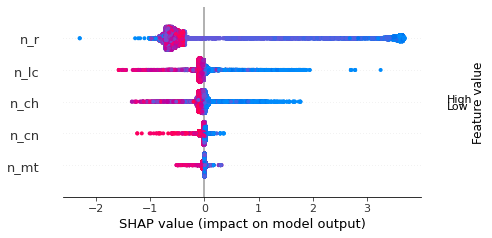

In [14]:
models = describe_clusters(clusterized, normalized, n_clusters, model=XGBClassifier, params={
    'n_estimators': [5],
    'random_state': [RANDOM_STATE],
    'seed': [RANDOM_STATE],
    'use_label_encoder': [False],
    'eval_metric': ['logloss']
})

In [15]:
X_test, y_test = test.iloc[:, 1:-1], test.iloc[:, -1]

In [16]:
preds = []
for i, entry in tqdm(X_test.iterrows(), total=len(X_test)):
    p = ovr_predict(models, entry)
    preds.append(p)

100%|████████████████████████████████████| 12500/12500 [01:01<00:00, 202.78it/s]


In [17]:
preds = np.array(preds)
reals = y_test.values.flatten()
preds.shape, reals.shape

((12500,), (12500,))

In [18]:
print(classification_report(reals, preds))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.93      0.96      0.95      3936
           1       1.00      1.00      1.00       252
           2       0.98      0.97      0.98      2398
           3       0.97      0.91      0.94      3993
           4       1.00      0.94      0.97      1921

    accuracy                           0.95     12500
   macro avg       0.81      0.80      0.81     12500
weighted avg       0.96      0.95      0.96     12500



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [28]:
medias = {x: df_[x].mean() for x in ['n_r', 'n_lc', 'n_mt', 'n_cn', 'n_ch']}

In [29]:
def analisa_grupo(g):
    G = clusterized[clusterized['cluster'] == g]
    for col in ['n_r', 'n_lc', 'n_mt', 'n_cn', 'n_ch']:
        print(col, '{:.2f}'.format(G[col].mean() * medias[col]), 'vs media ENEM {:.2f}'.format(medias[col]))

In [30]:
for i in range(7):
    print('GRUPO', i)
    analisa_grupo(i)
    print()

GRUPO 0
n_r 812.30 vs media ENEM 597.63
n_lc 599.98 vs media ENEM 521.76
n_mt 716.47 vs media ENEM 529.08
n_cn 594.55 vs media ENEM 476.75
n_ch 618.53 vs media ENEM 509.41

GRUPO 1
n_r 560.06 vs media ENEM 597.63
n_lc 481.35 vs media ENEM 521.76
n_mt 430.08 vs media ENEM 529.08
n_cn 400.94 vs media ENEM 476.75
n_ch 454.70 vs media ENEM 509.41

GRUPO 2
n_r 622.29 vs media ENEM 597.63
n_lc 527.89 vs media ENEM 521.76
n_mt 459.19 vs media ENEM 529.08
n_cn 495.93 vs media ENEM 476.75
n_ch 514.27 vs media ENEM 509.41

GRUPO 3
n_r 354.69 vs media ENEM 597.63
n_lc 453.91 vs media ENEM 521.76
n_mt 446.21 vs media ENEM 529.08
n_cn 420.46 vs media ENEM 476.75
n_ch 431.86 vs media ENEM 509.41

GRUPO 4
n_r 2.65 vs media ENEM 597.63
n_lc 445.04 vs media ENEM 521.76
n_mt 445.47 vs media ENEM 529.08
n_cn 412.67 vs media ENEM 476.75
n_ch 424.28 vs media ENEM 509.41

GRUPO 5
n_r 677.25 vs media ENEM 597.63
n_lc 559.56 vs media ENEM 521.76
n_mt 602.01 vs media ENEM 529.08
n_cn 531.19 vs media ENEM 476.7